In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [57]:
class aux(object):
    @staticmethod
    def imshow(img,text=None,should_save=False):
        npimg = img.numpy()
        plt.axis("off")
        if text:
            plt.text(75, 8, text, style='italic',fontweight='bold',
                bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()    
    @staticmethod
    def show_plot(iteration,loss):
        plt.plot(iteration,loss)
        plt.show()
    


class setup(object):
    training_dir = '/home/leleopc/Documentos/Sprint4/Autoencoder/data'
    testing_dir = '\home\leleopc\Documentos/Sprint4/Autoencoder/data/test'
    train_batch_size = 16
    train_number_epochs = 150
    
    def __init__(self):
        pass
    @classmethod
    def config(train_dir, test_dir, train_batch, train_epochs):
        training_dir = train_dir
        testing_dir = test_dir
        train_batch_size = train_batch #16#64 #1 #64
        train_number_epochs = train_epochs #150 #50 #100



In [58]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        #print(self.imageFolderDataset.imgs)
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print('im0 ' , img0_tuple[0], ' img0_tuple[1] ', img0_tuple[1])
        #50% das imagens devem estar na mesma classe
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
            #print('t1 ' , img1_tuple[0])
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
            #print('t1 - outra classe ' , img1_tuple[0])
 

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        print('img0_tuple[0] ' , img0_tuple[0], ' img1_tuple[0] ' , img1_tuple[0])
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)



In [60]:
folder_dataset = dset.ImageFolder(root=setup.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


img0_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/test/d_6.jpg  img1_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/d_2.jpg
img0_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/test/d_4.jpg  img1_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/test/d_4.jpg
img0_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/1.pgm  img1_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/test/d_5.jpg
img0_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/test/d_5.jpg  img1_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/d_3.jpg
img0_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/d_3.jpg  img1_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/1.pgm
img0_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/1.pgm  img1_tuple[0]  /home/leleopc/Documentos/Sprint4/Autoencoder/data/train/1.pgm


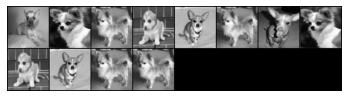

[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [62]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
aux.imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())